# Importing the pretrained network

In [1]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    # Legacy Python that doesn't verify HTTPS certificates by default
    pass
else:
    # Handle target environment that doesn't support HTTPS verification
    ssl._create_default_https_context = _create_unverified_https_context

In [2]:
import subprocess
import os

result = subprocess.run('bash -c "source /etc/network_turbo && env | grep proxy"', shell=True, capture_output=True, text=True)
output = result.stdout
for line in output.splitlines():
    if '=' in line:
        var, value = line.split('=', 1)
        os.environ[var] = value

In [3]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import shap
model = ResNet50(weights='imagenet')
X, y = shap.datasets.imagenet50()

2023-10-05 23:57:07.672511: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-05 23:57:07.820472: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-05 23:57:08.745943: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /root/autodl-tmp/program/g16/bsd:/root/autodl-tmp/program/g16:/root/autodl-tmp/program/

In [4]:
import json
import os
import urllib.request
json_file_path = 'imagenet_class_index.json' 
# Verify if the JSON file is on disk
if os.path.exists(json_file_path):
    with open(json_file_path) as file:
        class_names = [v[1] for v in json.load(file).values()]
else:
    url = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'
    with urllib.request.urlopen(url) as response:
        json_data = response.read().decode()
    with open(json_file_path, 'w') as file:
        file.write(json_data)
    class_names = [v[1] for v in json.loads(json_data).values()]

# Applying SHAP for image classification

In [5]:
# Wrapping the model 
def predict(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)
masker = shap.maskers.Image( 'blur(128,128)', shape = X[0].shape )

In [6]:
topk = 3 
# which of the 50 images to display 
index = [21, 28]
explainer = shap.Explainer( 
    predict, 
    masker, 
    output_names=class_names 
)
shap_values = explainer( 
    X[index], 
    max_evals=1000, 
    batch_size=50, 
    outputs=shap.Explanation.argsort.flip[:topk], 
    silent=True 
)

2023-10-05 23:57:20.194097: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8200
2023-10-05 23:57:22.097421: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


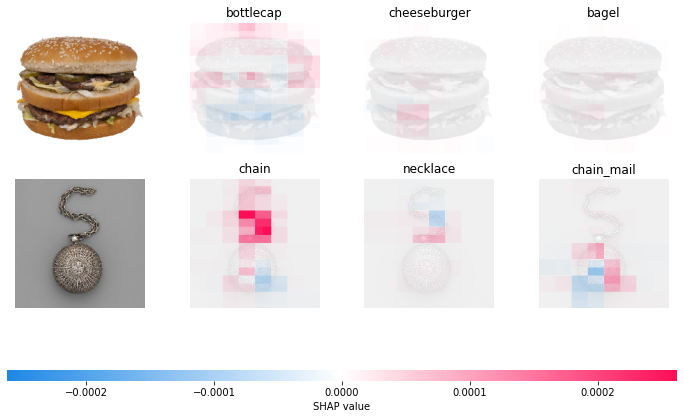

In [7]:
shap.image_plot(shap_values, pixel_values=X[index]/255)

# The impact of various maskers

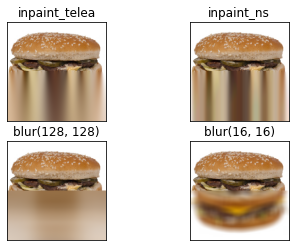

In [8]:
import matplotlib.pyplot as plt

# Define a masker to mask certain portions of the input image.
mask_names = ['inpaint_telea', 'inpaint_ns', 'blur(128, 128)', 'blur(16, 16)']
sh = X[0].shape
masks = [shap.maskers.Image(m, sh) for m in mask_names]

# Create a numpy array of the shape (224, 224, 3) 
arr = np.zeros((224 * 224 * 3), dtype=bool) 
# Set the upper half of the image to True 
arr[:75264] = True 
# Set the lower half of the image to False 
arr[75264:] = False 
fig, axs = plt.subplots(2, 2) 
ind = 0 
for i in [0, 1]: 
    for j in [0, 1]: 
        axs[i, j].imshow(masks[ind](x=X[21], mask=arr)[0][0] / 255)
        axs[i, j].set_title(mask_names[ind])
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].tick_params(axis='both', which='both', length=0)
        ind += 1
plt.show()

inpaint_telea


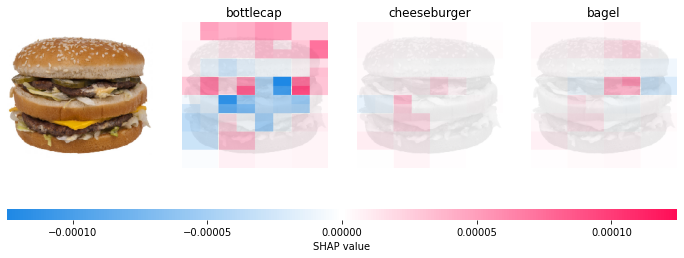

inpaint_ns


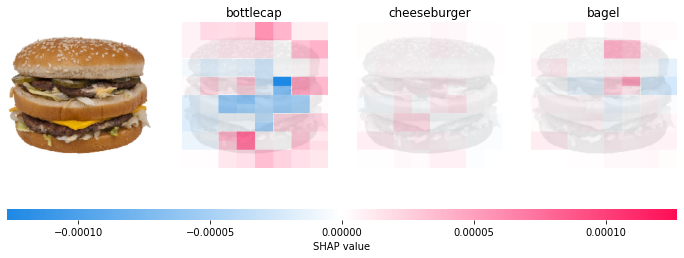

blur(128, 128)


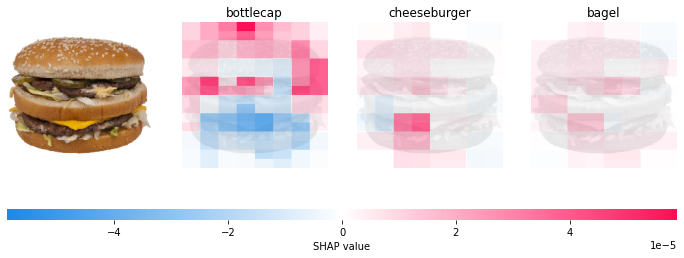

blur(16, 16)


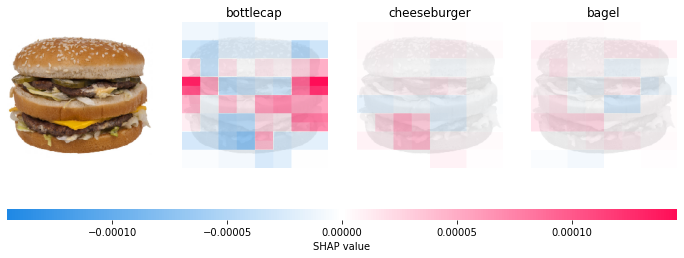

In [9]:
topk = 3
# Iterate through all the masks 
for mask_name in mask_names: 
    print(mask_name) 
    mask = shap.maskers.Image(mask_name, shape=sh) 
    explainer = shap.Explainer( predict, mask, output_names=class_names, silent=True ) 
    shap_values = explainer( X[[21]], max_evals=500, batch_size=50, outputs=shap.Explanation.argsort.flip[:topk] ) 
    shap.image_plot(shap_values, pixel_values=X[[21]] / 255)

# Effect of increasing the evaluation steps

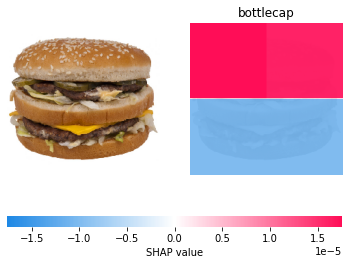

In [10]:
topk = 1
masker = shap.maskers.Image('blur(128, 128)', shape=sh)
explainer = shap.Explainer(predict, masker, output_names=class_names)
shap_values = explainer( X[[21]], max_evals=10, batch_size=50, outputs=shap.Explanation.argsort.flip[:topk] )
shap.image_plot(shap_values, pixel_values=X[[21]]/255)

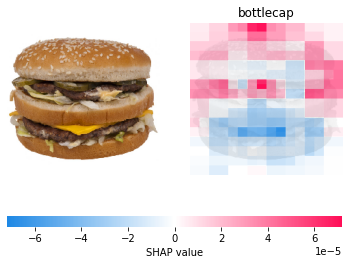

In [11]:
shap_values = explainer( X[[21]], max_evals=1000, batch_size=50, outputs=shap.Explanation.argsort.flip[:topk] )
shap.image_plot(shap_values, pixel_values=X[[21]]/255)